In [23]:
# Preamble
from astropy.table import Table, column, vstack
import numpy as np
import os
import pandas as pd

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import sys
sys.path.append('../../astro_codes/')

In [7]:
# Load the data
import pandas as pd
sparcfire_r = Table.read('../../sparcfire_directories/r/r.galaxy_matched.fits')
sparcfire_r_arcs = pd.read_csv('../../sparcfire_directories/r/r.galaxy_arcs.csv')

#### First task: define the sample. How many galaxies do we have?

* Load the Spotter data
* Check the number of classifications

In [8]:
from combining_catalogues import match_ids, make_matched_catalogue

spotter_subjects = Table.read('../../SpiralSpotter/tables/spiral_spotter_sparcfire_subjects.fits')
spotter_data = Table.read('../../SpiralSpotter/tables/spiral_spotter_sparcfire_data.fits')

matched_rows = match_ids(spotter_subjects,spotter_data,
                         'subject_id','subject_id')

matched_data = make_matched_catalogue(spotter_subjects,spotter_data,
                                      matched_rows)

matched_data['dr7id'] = spotter_subjects['dr7objid']
matched_data['dr8id'] = spotter_subjects['dr8objid']
matched_data.write('spotter_subjects_matched.fits',overwrite=True)
spotter_data = matched_data.copy()

500 galaxies in the reference catalogue
468 galaxies in the match catalogue
---> 457 matches in total


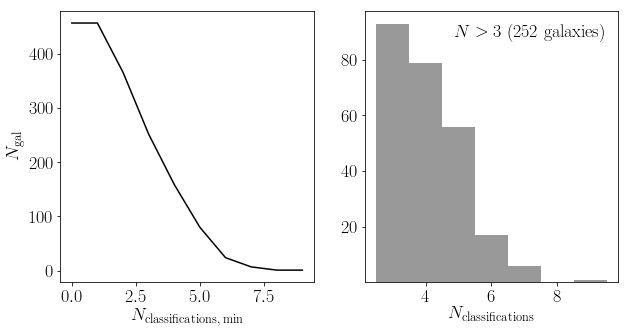

In [237]:
N_ok = []
N_classifications = []

for N in range(10):
    N_ok.append((spotter_data['total'] >= N).sum())
    N_classifications.append(N)

fig, axarr = plt.subplots(1,2,figsize=(10,5))
plt.sca(axarr[0])
_ = plt.plot(N_classifications,N_ok,color='k')
_ = plt.xlabel('$N_\mathrm{classifications, \, min}$')
_ = plt.ylabel('$N_\mathrm{gal}$')

class_ok = spotter_data['total'] >= 3
plt.sca(axarr[1])
_ = plt.hist(spotter_data['total'][class_ok],bins=np.linspace(2.5,9.5,8),
             color='k',alpha=0.4)
_ = plt.xlabel('$N_\mathrm{classifications}$')
_ = plt.text(0.95,0.95,'$N>{}$ ({} galaxies)'.format(3,class_ok.sum()),
             transform=axarr[1].transAxes,ha='right',va='top')

good_ids = spotter_data['dr8id'][class_ok]
spotter_data['class_ok'] = class_ok

#### Now, we match up the _p_ scores to their arcs

In [26]:
from arc_data import ArcData, ParamikoClient

arc_tables = []
for id_ in good_ids:
    arc_tables.append(ArcData(id_).arc_parameters(sparcfire_r_arcs,
                                                   sparcfire_r))
    
arc_table_spotted = vstack(arc_tables)

In [60]:
def match_arc_scores(arc_table,galaxy_table,
                     arc_id='gxyName',galaxy_id='dr8id'):
    labels = ('good','poor','weak','extension','junk','missing')
    ids = np.unique(arc_table['gxyName'])
    N_arc_rows = len(arc_table)
    for label in labels:
        arc_table['p_{}'.format(label)] = np.zeros(N_arc_rows,
                                                   dtype=np.float16)
    for id_ in ids: 
        masked_arc_rows = arc_table[arc_id] == id_
        masked_galaxy_row = galaxy_table[galaxy_id] == id_
        arc_rows = arc_table[masked_arc_rows]
        galaxy_row = galaxy_table[masked_galaxy_row]
        N_arcs = masked_arc_rows.sum()
        for label in labels:
            column_values = []
            for n in range(N_arcs):
                column_name = 'arc{}_{}_frac'.format(n+1,label)
                arc_column_name = 'p_{}'.format(label)
                column_values.append(galaxy_row[column_name][0])
            arc_table[arc_column_name][masked_arc_rows] = column_values
            
    return arc_table

arc_table = match_arc_scores(arc_table_spotted,spotter_data)

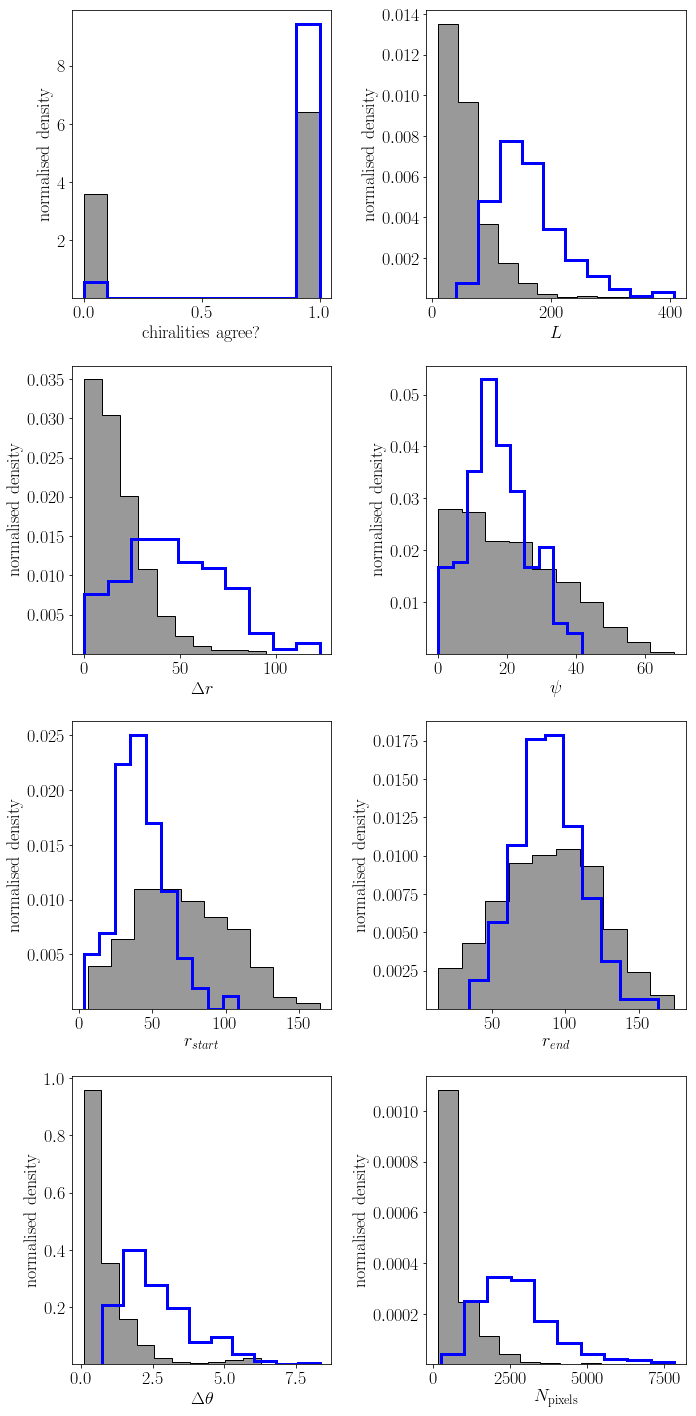

In [75]:
def arc_histogram(ax,data,bins,variable_column,feature_column,
                  p_threshold=0.5,label='good',xlabel='$L$',color='r',
                  reference=True):
    good_rows = data[feature_column] >= p_threshold
    bad_rows = data[feature_column] < p_threshold
    good_label = '$p_\mathrm{{{}}}>{} \, (N_\mathrm{{arcs}}={})$'.format(label,p_threshold,
                                                           good_rows.sum())
    bad_label = '$p_\mathrm{{{}}}\leq{} \, (N_\mathrm{{arcs}}={})$'.format(label,p_threshold,
                                                             bad_rows.sum())
    if reference is True:
        _ = ax.hist(data[variable_column][bad_rows],bins,normed=True,
                    color='k',alpha=0.4,label=bad_label)
        _ = ax.hist(data[variable_column][bad_rows],bins,normed=True,
                    histtype='step',color='k')
    _ = ax.hist(data[variable_column][good_rows],bins,normed=True,
                histtype='step',color=color,lw=3,label=good_label)
    _ = ax.set_xlabel(xlabel)
    _ = ax.set_ylabel('normalised density')
    #_ = ax.legend(fontsize=15)
    return ax


def arc_scatter(ax,data,x_column,y_column,feature_column,
                p_threshold=0.5,label='good',xlabel='x',ylabel='y',
                color='g',reference=True):
    good_rows = data[feature_column] >= p_threshold
    bad_rows = data[feature_column] < p_threshold
    good_label = '$p_\mathrm{{{}}}>{} \, (N_\mathrm{{arcs}}={})$'.format(label,p_threshold,
                                                           good_rows.sum())
    bad_label = '$p_\mathrm{{{}}}\leq{} \, (N_\mathrm{{arcs}}={})$'.format(label,p_threshold,
                                                             bad_rows.sum())
    if reference is True:
        _ = ax.scatter(data[x_column][bad_rows],data[y_column][bad_rows],
                       color='k',s=2,alpha=0.4)
    _ = ax.scatter(data[x_column][good_rows],data[y_column][good_rows],
                   color=color,s=12)
    _ = ax.set_xlabel(xlabel)
    _ = ax.set_ylabel(ylabel)
    return ax

arc_params = ['chirality_agreement','arc_length','delta_r',
              'pitch_angle_absolute','r_start','r_end',
              'relative_theta_end','num_pixels']

xlabel_list = ['chiralities agree?','$L$','$\Delta r$','$\psi$',
               '$r_{start}$','$r_{end}$',r'$\Delta \theta$','$N_\mathrm{pixels}$']

fig, axarr = plt.subplots(4,2,figsize=(10,20))
axarr = axarr.ravel()
#fig.delaxes(axarr[-1])
for a, arc_param in enumerate(arc_params):
    ax = axarr[a]
    xlabel = xlabel_list[a]
    bins = [-0.5,0.5,1.5]

    ax = arc_histogram(ax,arc_table_spotted,None,arc_param,'p_good',
                       xlabel=xlabel,color='b')
    #ax = arc_histogram(ax,arc_table_spotted,None,arc_param,'p_extension',
                       #xlabel=xlabel,color='r',reference=False)
    #ax = arc_histogram(ax,arc_frame_full,None,arc_param,'p_extension',
                       #xlabel=xlabel,color='r',reference=False)
    
fig.tight_layout()
#_ = ax.legend(bbox_to_anchor=(1.8,0.5),loc='center')

#### Now: can we use the sklearn methods to tell us whether an arc is true or not?

In [178]:
def completeness_and_contamination(y_predicted,y):
    predicted_positive = y_predicted>0.5#[:,1] > 0.5
    predicted_negative = y_predicted<=0.5#[:,1] <= 0.5
    true_positive = y
    true_negative = y == False
    completeness = (true_positive*predicted_positive).sum()/true_positive.sum()
    contamination = (true_negative*predicted_positive).sum()/predicted_positive.sum()
    return completeness, contamination


def test_and_plot_classifier(ax,X,y,xlabels,clf,plot=True):
    _, N_params = X.shape
    X_scaled = StandardScaler().fit_transform(X)
    completenesses, contaminations = [], []
    for n in range(N_params):
        X_n = X[:,:n+1]
        X_n = StandardScaler().fit_transform(X_n)
        X_train, X_test, y_train, y_test = \
          train_test_split(X_n,y,test_size=0.25,random_state=0)
        
        clf.fit(X_train,y_train)
        score = clf.score(X_test,y_test)
        y_predicted = clf.predict(X_test)
        completeness, contamination = completeness_and_contamination(y_predicted,
                                                                     y_test)
        completenesses.append(completeness)
        contaminations.append(contamination)
    if plot is True:
        plt.sca(ax)
        _ = plt.plot(completenesses,color='g',lw=2,marker='o',
                    label='completeness',)
        _ = plt.plot(contaminations,color='r',lw=3,linestyle='dashed',marker='s',
                     label='contamination')
        _ = plt.xticks(range(N_params),xlabels)
        _ = plt.setp(plt.xticks()[1], rotation=45)
        _ = plt.xlabel('input parameters')
        _ = plt.ylabel('statistic')
    return clf

from astroML.utils import completeness_contamination

class Classifier():
    def __init__(self,clf,X,y):
        self.X_scaled = StandardScaler().fit_transform(X)
        self.X_train, self.X_test, self.y_train, self.y_test = \
         train_test_split(self.X_scaled,y,test_size=0.25,random_state=0)
        self.clf = clf
        
    def fit(self):
        clf.fit(self.X_train,self.y_train)
        self.y_probabilities = clf.predict_proba(self.X_test)
        self.y_classes = clf.predict(self.X_train)
        
    def ROC_curve(self,ax,plot=True,probs=np.linspace(0.1,0.9,17),**kwargs):
        tp_rates = []
        fp_rates = []
        for prob in probs:   
            y_predicted = self.y_probabilities[:,1] >= prob
            tp, fp = self.ROC_rates(y_predicted,self.y_test)
            tp_rates.append(tp)
            fp_rates.append(fp)
        if plot is True:
            ax.plot(fp_rates,tp_rates,**kwargs)
            ax.set_xlabel('fp rate')
            ax.set_ylabel('tp rate')
        rates_table = Table(np.array([probs,tp_rates,fp_rates]).T,
                            names=('p','tp_rate','fp_rate'))
        return rates_table
        
    def ROC_rates(self,y_predicted,y_true):
        true_positive = y_true == 1
        true_negative = y_true == 0 
        predicted_positive = y_predicted == 1
        predicted_negative = y_predicted == 0
        tp_rate = (true_positive*predicted_positive).sum()/predicted_positive.sum()
        fp_rate = (true_positive*predicted_negative).sum()/predicted_negative.sum()
        return tp_rate, fp_rate
    
    def CC_curve(self,ax,plot=True,probs=np.linspace(0.1,0.9,17),
                                            **kwargs):
        completenesses = []
        contaminations = []
        for prob in probs:   
            y_predicted = self.y_probabilities[:,1] >= prob
            completeness, contamination = completeness_contamination(y_predicted,self.y_test)
            completenesses.append(completeness)
            contaminations.append(contamination)
        efficiencies = [1-c for c in contaminations]
        if plot is True:
            ax.plot(efficiencies,completenesses,**kwargs)
            ax.set_xlabel('efficiency')
            ax.set_ylabel('completeness')
        rates_table = Table(np.array([probs,completenesses,contaminations]).T,
                            names=('p','completeness','efficiency'))
        return rates_table

In [83]:
arc_params_less = arc_params[1:]
xlabels_less = xlabel_list[1:]

X = np.array([arc_table_spotted[arc_param] for arc_param in arc_params_less]
             ,dtype='float64').T

y = np.array(arc_table_spotted['p_good'] >= 0.5)#[:,np.newaxis]

In [84]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

mlp_parameters = {'alpha':[0.01,0.1,1,10]}
svc_parameters =  {'gamma':[0.01,0.1,1,10],'C':[0.01,0.1,1,10]}
kn_parameters = {'weights':['uniform','distance'],'p':[1,2]}

classifiers = [GridSearchCV(MLPClassifier(random_state=0),
                            mlp_parameters),
               GaussianNB(),
               GridSearchCV(SVC(random_state=0,probability=True),
                            svc_parameters),
               GridSearchCV(KNeighborsClassifier(),
                            kn_parameters),
               #GaussianProcessClassifier(random_state=0)
               ]

/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


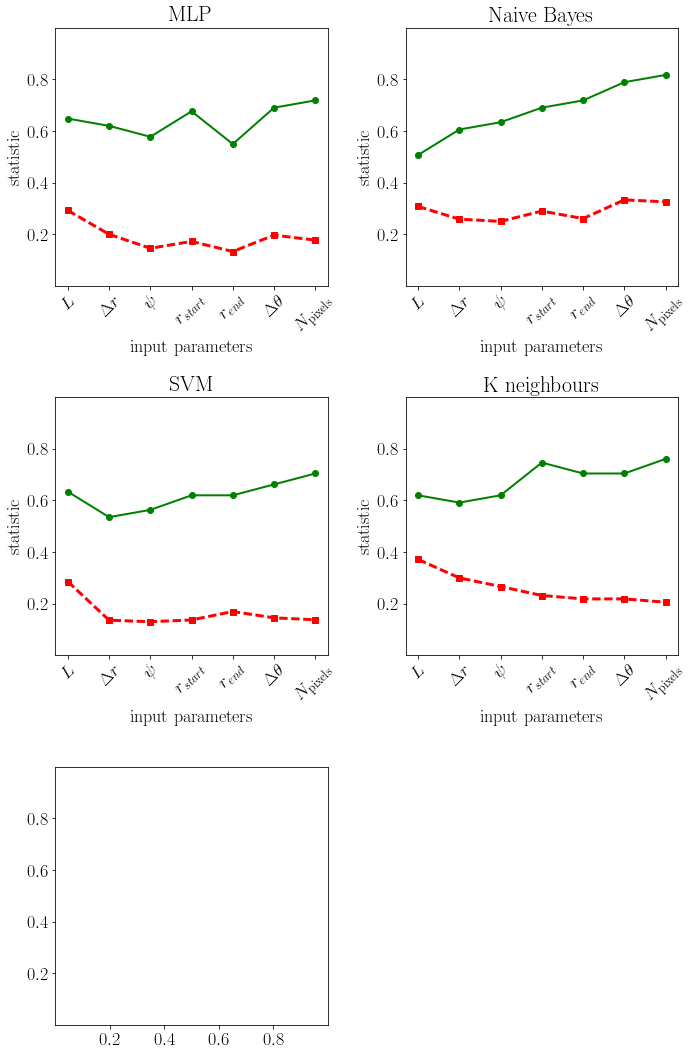

In [91]:
fig, axarr = plt.subplots(3,2,figsize=(10,15))
axarr = axarr.ravel()
fig.delaxes(axarr[-1])

figlabels = ('MLP','Naive Bayes','SVM','K neighbours','Gaussian process')

for c, clf in enumerate(classifiers):
    ax = axarr[c]
    test_and_plot_classifier(ax,X,y,xlabels_less,clf)
    ax.set_title(figlabels[c])
    ax.set_ylim(0,1)
    
#_ = axarr[4].plot([0,1],[0,1],color='k',label='OI')
_ = axarr[4].legend(loc='center',bbox_to_anchor=(1.8,0.5),
                    fancybox=False,edgecolor='k')

fig.tight_layout()

(0, 1)

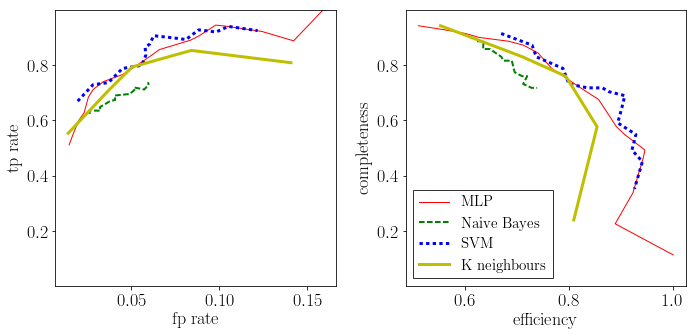

In [180]:
fig, axarr = plt.subplots(1,2,figsize=(10,5))
colors = 'rgby'
linestyles = ('solid','dashed','dotted','solid')
linewidths = (1,2,3,3)
labels = figlabels

for c, clf in enumerate(classifiers):
    clf_plotter = Classifier(clf,X,y)
    clf_plotter.fit()
    clf_plotter.ROC_curve(axarr[0],color=colors[c],lw=linewidths[c],
                          linestyle=linestyles[c],label=labels[c])
    clf_plotter.CC_curve(axarr[1],color=colors[c],lw=linewidths[c],
                         linestyle=linestyles[c],label=labels[c])
    
_ = axarr[-1].legend(fontsize=15,fancybox=False,edgecolor='k')
fig.tight_layout()
axarr[0].set_ylim(0,1)
axarr[1].set_ylim(0,1)

#### Now see what the classifier does to a normal subset of galaxies:

- Make a plot of true +ve, false +ve, true -ve and false -ve to see where the module is doing well/poorly?

In [192]:
best_clf = GridSearchCV(SVC(random_state=0,probability=True),
                        svc_parameters)
# ^Deemed to be the ~tied best classifier according to the ROC+CC analysis

X_scaled = StandardScaler().fit_transform(X)
best_clf.fit(X_scaled,y)
p_good_model = best_clf.predict(X_scaled)
arc_table_spotted['p_good_model'] = p_good_model

# Now create 'labels' for each of the classifications
real_positive = arc_table_spotted['p_good'] >= 0.5
real_negative = arc_table_spotted['p_good'] < 0.5
predicted_positive = arc_table_spotted['p_good_model'] == 1
predicted_negative = arc_table_spotted['p_good_model'] == 0

model_labels = np.zeros(len(arc_table_spotted))
model_labels[(predicted_positive*real_positive).astype(bool)] = 1 # true +ve
model_labels[(predicted_positive*real_negative).astype(bool)] = 2 # false +ve
model_labels[(predicted_negative*real_positive).astype(bool)] = 3 # false -ve
model_labels[(predicted_negative*real_negative).astype(bool)] = 4 # true -ve
arc_table_spotted['model_labels'] = model_labels

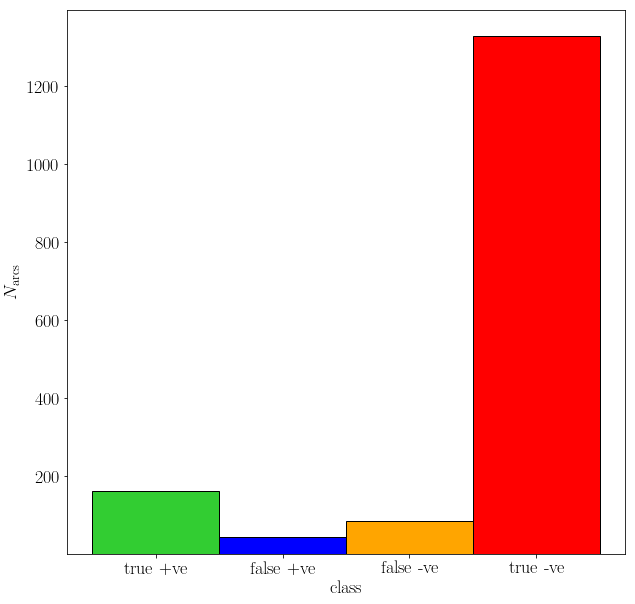

In [268]:

figure = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

bins = np.linspace(0.5,4.5,5)
_, _ , patches = plt.hist(model_labels,bins)
colors = ('limegreen','b','orange','r')
for i in range(len(patches)):
    patches[i].set_facecolor(colors[i])
    patches[i].set_linewidth(1)
    patches[i].set_edgecolor('k')

xlabels = ('true +ve','false +ve','false -ve','true -ve')
_ = ax.set_xticks([1,2,3,4])
_ = ax.set_xticklabels(xlabels)
_ = ax.set_xlabel('class')
_ = ax.set_ylabel('$N_\mathrm{arcs}$')

#### Now for the images!

In [242]:
gz2_data = Table.read('../../fits/full_sample_debiased_w_low_z.fits')

In [243]:
has_good_arm = [] # only do galaxies where people said there was >= 1 good arm!
for id_ in good_ids:
    arc_frame_id = arc_table_spotted[arc_table_spotted['gxyName'] == id_]
    has_good_arm.append(np.any(arc_frame_id['p_good'] > 0.5))

spotter_data['has_good_arm'] = np.zeros(len(spotter_data))
spotter_data['has_good_arm'][class_ok] = has_good_arm

print('{}/{} galaxies have >1 good arms'.format(np.sum(has_good_arm),
                                                len(has_good_arm)))

126/252 galaxies have >1 good arms


In [249]:
def get_row(id_,gz2_data):
    
    m_colnames = ['t11_arms_number_a31_1_debiased_rh',
                  't11_arms_number_a32_2_debiased_rh',
                  't11_arms_number_a33_3_debiased_rh',
                  't11_arms_number_a34_4_debiased_rh',
                  't11_arms_number_a36_more_than_4_debiased_rh']
    
    w_colnames = ['t10_arms_winding_a28_tight_debiased_rh',
                  't10_arms_winding_a29_medium_debiased_rh',
                  't10_arms_winding_a30_loose_debiased_rh']
    
    gz2_row = gz2_data[gz2_data['dr8objid'] == id_]
    m = np.argmax([gz2_row[c] for c in m_colnames]) + 1
    w = np.argmax([gz2_row[c] for c in w_colnames]) + 1
    return m, w

best_mask = spotter_data['has_good_arm'].astype(bool)
best_ids = spotter_data['dr8id'][best_mask]

m_list = []
w_list = []
for id_ in best_ids:
    m, w = get_row(id_,gz2_data)
    m_list.append(m)
    w_list.append(w)

spotter_gz2_array = np.array([best_ids,m_list,w_list]).T
spotter_gz2_table = Table(spotter_gz2_array,names=('id','m','w'),
                          dtype=('int64','int','int'))

KeyError: 'dr8id'

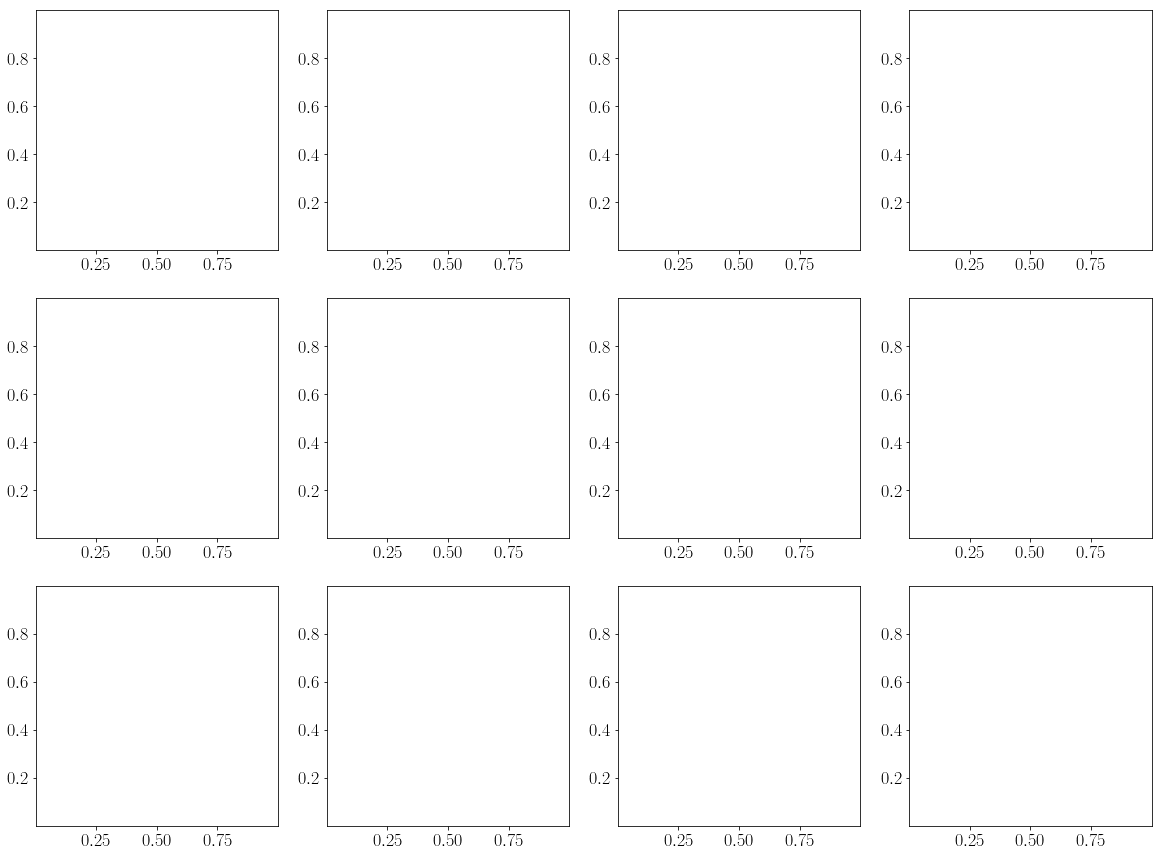

In [269]:
np.random.seed(0)
N_sample_galaxies = 3
plot_id_array = np.empty((N_sample_galaxies,4),dtype=np.int64)
for m in range(4):
    in_m = spotter_gz2_table['m'] == m+2
    m_ids = spotter_gz2_table['id'][in_m]
    random_ids = np.random.choice(m_ids,N_sample_galaxies,
                                  replace=False)
    plot_id_array[:,m] = random_ids
plot_ids = plot_id_array.ravel()

fig, axarr = plt.subplots(3,4,figsize=(20,15))
axarr = axarr.ravel()

for id_, ax in zip(plot_ids,axarr):
    #arcstats = ArcData(id_)
    arc_classes = arc_table_spotted[arc_table_spotted['dr8id'] == id_]
    print(len(arc_classes))
    #arc_data = arcstats.arc_parameters(sparcfire_r,sparcfire_r)

#### Final stage: have a look at some of the output images to see what they look like

In [265]:
help(ArcData)

Help on class ArcData in module arc_data:

class ArcData(builtins.object)
 |  Methods defined here:
 |  
 |  __init__(self, dr8id, band='r', save_directory='save_images')
 |  
 |  arc_parameters(self, arc_file, galaxy_file, N_max=8)
 |  
 |  display_image(self, ax, suffix='B_autoCrop', file=None, client=None)
 |  
 |  download_remote_file(self, client, suffix='B_autoCrop', overwrite=False)
 |  
 |  download_remote_folder(self, client, overwrite=False)
 |  
 |  draw_arcs(self, ax, arc_file, galaxy_file, label=True, N_max=8, colors=None, **kwargs)
 |  
 |  draw_ellipse(self, ax, galaxy_file, **kwargs)
 |  
 |  measure_chirality(self, galaxy_file)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



In [551]:
#samples = Table.read('../../fits/SF_fits/samples.fits')


In [267]:
arc_table

gxyName,alenRank,math_initial_theta,pitch_angle,math_initial_radius,relative_theta_start,relative_theta_end,r_start,r_end,used2rev,failed2rev,hasUndefinedEndpoints,arc_length,num_pixels,err_per_len,err_per_pixel,mean_intensity,brt_ratio_score,anovaF_score,clusOutputColor,chirality_agreement,pitch_angle_absolute,delta_r,p_good,p_poor,p_weak,p_extension,p_junk,p_missing,p_good_model
object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,bool,object,object,float16,float16,float16,float16,float16,float16,bool
1237661949727735904,1,7.37402,-14.705957000000001,56.680009999999996,0.0,1.919344,56.680009999999996,93.80005799999999,0,0,0,146.22337,2687.0,711.789965,38.734770000000005,0.42847700000000005,1.159727,369.38771,[1_0.9231_0],True,14.705957000000001,37.120048,1.0,0.0,0.0,0.0,0.0,0.0,True
1237661949727735904,2,4.8603559999999995,-12.338695,51.735714,0.0,1.917659,51.735714,78.698379,0,0,0,126.176428,1582.0,202.287777,16.133975,0.46343199999999996,1.059769,69.88533000000001,[1_0_0.9231],True,12.338695,26.962665,1.0,0.0,0.0,0.0,0.0,0.0,False
1237661949727735904,3,10.702247999999999,-14.802647,81.643699,0.0,0.919451,81.643699,104.09869599999999,0,0,0,87.889778,1275.0,109.63686399999999,7.557614999999999,0.313725,1.102757,194.402413,[0_1_0.7692],True,14.802647,22.45499699999999,1.0,0.0,0.0,0.0,0.0,0.0,False
1237661949727735904,4,7.312257000000001,-31.098985,22.120034,0.0,1.6639540000000002,22.120034,60.352654,0,0,0,74.019894,671.0,125.88988,13.887266,0.638478,1.03041,24.347742999999998,[0_1_0.3077],True,31.098985,38.23262,0.0,0.33325,0.33325,0.0,0.0,0.33325,False
1237661949727735904,5,9.524746,20.611359,52.946785999999996,0.0,1.2220600000000001,33.437193,52.946785999999996,0,0,0,55.420694999999995,495.0,67.315702,7.536733,0.635417,1.030057,27.832931,[0.6154_1_0],False,20.611359,19.509592999999995,0.0,0.0,0.0,0.0,0.0,1.0,False
1237661949727735904,6,6.9505550000000005,40.303204,107.41188100000001,0.0,0.419433,75.258239,107.41188100000001,0,0,0,49.709384,493.0,57.000471999999995,5.747380000000001,0.315048,1.04912,9.163997,[0.6154_0_1],False,40.303204,32.153642000000005,0.0,0.0,0.0,0.0,0.0,1.0,False
1237661949727735904,7,10.723605000000001,-9.419994,30.822141,0.0,1.0534729999999999,30.822141,36.708648,0,0,0,35.965656,293.0,43.379127000000004,5.324774,0.685161,1.023291,40.374302,[0_0.7692_1],True,9.419994,5.886506999999998,0.0,0.0,0.0,0.0,0.0,1.0,False
1237661949727735904,8,12.257477,28.197956,134.35339199999999,0.0,0.223369,119.189494,134.35339199999999,0,0,0,32.091594,192.0,11.943029,1.996202,0.261418,1.1828379999999998,59.093577,[1_0_0.4615],False,28.197956,15.163897999999989,0.0,0.0,0.0,0.0,0.0,1.0,False
1237667536936894657,1,2.6112580000000003,-15.636080999999999,32.187936,0.0,3.7898339999999995,32.187936,92.972669,0,0,0,225.524304,3703.0,421.466492,25.66863,0.47858500000000004,1.193758,813.669362,[1_0_0.8571],True,15.636080999999999,60.784732999999996,1.0,0.0,0.0,0.0,0.0,0.0,True


[]

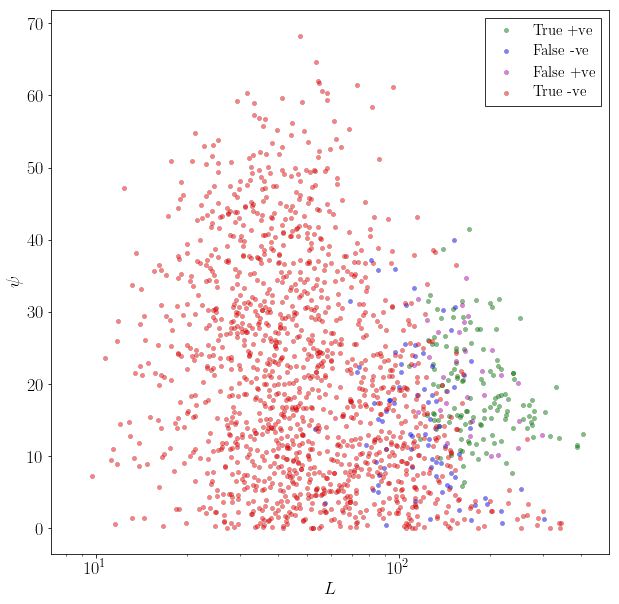

In [621]:
def scatter_p(ax,arc_frame,x_column,y_column,xlabel='x',ylabel='y',
              **kwargs):
    colors = 'gbmr'
    labels = ('True +ve','False -ve','False +ve','True -ve')
    # set up the masks:
    checked_positive = arc_frame['p_good'] > 0.5
    checked_negative = arc_frame['p_good'] <= 0.5
    predicted_positive = arc_frame['p_good_predicted'] > 0.5
    predicted_negative = arc_frame['p_good_predicted'] <= 0.5
    masks = [np.all([checked_positive,predicted_positive],axis=0),
             np.all([checked_positive,predicted_negative],axis=0),
             np.all([checked_negative,predicted_positive],axis=0),
             np.all([checked_negative,predicted_negative],axis=0)]
    for color, mask, label in zip(colors,masks,labels):
        ax.scatter(arc_frame[x_column][mask],arc_frame[y_column][mask],
                   color=color,label=label,**kwargs)
        
    _ = ax.set_xlabel(xlabel)
    _ = ax.set_ylabel(ylabel)
    _ = ax.legend(fontsize=15,fancybox=False,edgecolor='k')
    return None

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

_ = scatter_p(ax,arc_frame_full,'length','pitch_angle','$L$','$\psi$',
              s=20,linewidths=0.25,edgecolors='k',alpha=0.5)

ax.semilogx()